# Pipeline for Classification

In [28]:
import os
import tensorflow.keras as keras
import numpy as np
from PIL import Image
from pydub import AudioSegment
import matplotlib.pyplot as plt
from tempfile import mktemp
from scipy.io import wavfile

In [29]:
model=keras.models.load_model("model.h5")

In [30]:
genre_name_map={0: 'Blues',
 1: 'Classical',
 2: 'Country',
 3: 'Disco',
 4: 'Hiphop',
 5: 'Jazz',
 6: 'Metal',
 7: 'Pop',
 8: 'Reggae',
 9: 'Rock'}

In [31]:
def get_audiodata(filepath,filetype):
    wname = mktemp('.wav')
    filepath=filepath
    sound=AudioSegment.from_file(filepath,filetype)
    sound.export(wname,format="wav")
    samplingfreq,signaldata= wavfile.read(wname)
    os.unlink(wname)
    return samplingfreq,signaldata

In [32]:
def generate_specgram(filepath,filetype):
    
    samplingfreq,signaldata=get_audiodata(filepath,filetype)
    
    if(len(signaldata.shape)==2):
        signaldata=signaldata[:,0]
    
    fig=plt.figure(frameon=False)
        
    ax=plt.Axes(fig, [1.,1.,1.,1.])
    fig.set_size_inches(6,1)
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
        
    ax.specgram(signaldata, Fs=samplingfreq, NFFT=1024, noverlap=0 ,cmap="gray")
    
    tempf = mktemp('.png')    
    fig.savefig(tempf,bbox_inches='tight',pad_inches=0,dpi=128)
    tempgram=Image.open(tempf).convert("L")
    os.unlink(tempf)
    return np.asarray(tempgram)

In [103]:
class Prediction:
    def __init__(self,predictions):
        self.predictions=predictions
        
        pred=predictions[0]
        for i in range(1,6):
            pred=pred+predictions[i]
        pred=pred/6
        self.pred=pred
        
    def pred_by_seg(self):
        print("Genre predictions for each segment: ")
        for i in self.predictions:
            print(genre_name_map[np.argmax(i)],":",round(np.max(i)*100,4),"%")
            
    def pred_by_seg_broken(self):
        print("Genre predictions for each segment broken by class: ")
        x=1
        for i in self.predictions:
            print("\nSegment:",x)
            x=x+1
            for j in range(0,10):
                print(genre_name_map[j],":",round(i[0][j]*100,4),"%")
    
    def pred_agg(self):
        print("\nAggregate genre prediction:")
        if(np.max(self.pred)<0.8):
            print("Not Sure. Tentative Class: ",genre_name_map[np.argmax(self.pred)],":",round(np.max(self.pred)*100,4),"%")
            self.pred_by_seg()
                
        else:
            print("Class is:",genre_name_map[np.argmax(self.pred)],":",round(np.max(self.pred)*100,4),"%")
    
    def pred_agg_broken(self):
        print("\nPercentage of likelihood for all genres: ")
        for i in range(0,10):
            print(genre_name_map[i],":",round(self.pred[0][i]*100,4),"%")

In [104]:
def prediction(specgram,model):
    seg_spec_arr=list()
    for i in range(128,769,128):
        seg_spec_arr.append(np.expand_dims(specgram[:,i-128:i].reshape(128,128,1),axis=0))

    predictions=list()
    for i in range(0,6):
        predictions.append(model.predict(seg_spec_arr[i]))
    
        
    return Prediction(predictions)

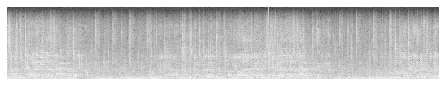

In [105]:
#Spectrogram is loaded as numpy array

filepath="/run/media/sangram/Games and Study Materials/Projects/Song Genre Classifier/genres/rock/rock.00020.au"
specgram=generate_specgram(filepath,'au') #use if loading from audio file. change "au" to relevant file type like mp3 or wav
#specgram=np.asarray(Image.open(filepath).convert("L")) #use if spectrogram is already generated

specgram=specgram/255.0

In [106]:
predict=prediction(specgram,model)

In [107]:
predict.pred_agg()


Aggregate genre prediction:
Not Sure. Tentative Class:  Rock : 78.9702 %
Genre predictions for each segment: 
Rock : 99.9308 %
Rock : 99.9995 %
Rock : 100.0 %
Rock : 100.0 %
Rock : 73.8861 %
Disco : 99.9949 %
